In [338]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.feature_selection import RFE
import plotly.express as px

## IMPORT DATASET AND CREATE MORE USEFUL COLUMNS

In [339]:
df = pd.read_csv("capstone_2014&2019.csv")

In [340]:
## here I am making several column adjustments to get more useful information to work with 

In [341]:
## add existing users of public healthcare with those without healthcare to get the total target number 
df["need_coverage"] = df["2019_total_no_coverage"] + df["2019_total_w_pbcoverage"] 

In [342]:
## convert the target into a percentage of the total population 
df["percent_need_coverage"] = df["need_coverage"] / df["2019_total_pop"]

In [343]:
## remove columns that have been added to create the target variables
df.drop(['2019_total_no_coverage','2019_total_w_pbcoverage','2019_total_pop'],axis=1,inplace=True)

In [344]:
## do the same with the input year data, it might help with predictions in a linear model 
df["2014_need_coverage"] = df["total_no_coverage"] + df["total_w_pbcoverage"]
df["2014%need_coverage"] = df["2014_need_coverage"] / df["total_pop"]

In [345]:
## rename columns so that they can be properly used in an OLS regression 
## this was done after a recursive factor elimination chose these as good predictors 
df.rename(columns = {'Total_16&Over':"total_sixteen_yrs_plus",
                     '25-44years':"twentyfive_to_fortyfour_yrs", 
                     '45-64years':"fortyfive_to_sixtyfour_yrs", 
                     '65+years':"sixtyfive_yrs_plus",},inplace=True)

In [346]:
## Variables to change to percentage of overall population 
## These are mostly variables that were found using RFE

df["percentage_Employed"] = df["Employed"] / df["total_pop"]
df["percentage_Unemployed"] = df["Unemployed"] / df["total_pop"]
df["percentage_fortyfive_to_sixtyfour_yrs"] = df["fortyfive_to_sixtyfour_yrs"] / df["total_pop"]
df["percentage_households_not_receiving_benefits"] = df["households_not_receiving_benefits"] / df["total_pop"]

df["percentage_sixtyfive_yrs_plus"] = df["sixtyfive_yrs_plus"] / df["total_pop"]
df["percentage_no_coverage"] = df["total_no_coverage"] / df["total_pop"]
df["percentage_female"] = df["total_pop_female"] / df["total_pop"]
df["percentage_male"] = df["total_pop_male"] / df["total_pop"]

df["percentage_sixteen_yrs_plus"] = df["total_sixteen_yrs_plus"] / df["total_pop"]
df["percentage_w_pbcoverage"] = df["total_w_pbcoverage"] / df["total_pop"]
df["percentage_twentyfive_to_fortyfour_yrs"] = df["twentyfive_to_fortyfour_yrs"] / df["total_pop"]

## make these percentages as well, to continue testing my hypothesis 

df["percentage_Grade_School"] = df["Grade_School"] / df["total_pop"]
df["percentage_HS_Diploma_GED"] = df["HS_Diploma_GED"] / df["total_pop"]
df["percentage_Higher_Ed"] = df["Higher_Ed"] / df["total_pop"]

In [347]:
## see if I can separate counties by size in any meaningful way 
print("Largest county population = " + str(df["total_pop"].max()))
print("Smallest county population = " + str(df["total_pop"].min()))
print("Average county population = " + str(round(df["total_pop"].mean())))

print("Counties with pop under 15K = " + str(df[df["total_pop"] < 15000].county_index.count()))
print("Counties with pop between 15K & 36K = " + str(df[(df["total_pop"] > 15000) & (df["total_pop"] < 36000)].county_index.count()))
print("Counties with pop over 36K = " + str(df[df["total_pop"] > 36000].county_index.count()))

Largest county population = 1184091
Smallest county population = 3455
Average county population = 61881
Counties with pop under 15K = 30
Counties with pop between 15K & 36K = 28
Counties with pop over 36K = 29


In [348]:
## separate counties by population size into a categorical value column 
## 1 = small 
## 2 = medium 
## 3 = large 

df["county_size"] = 0 
df.loc[df["total_pop"]<=15000,"county_size"]=1
df.loc[(df["total_pop"]>15000)&(df["total_pop"]<36000),"county_size"]=2
df.loc[df["total_pop"]>=36000,"county_size"]=3

In [349]:
str((round(df["2014%need_coverage"].min(),2))*100) + "%"

'20.0%'

In [350]:
## see if I can separate the "need_coverage2014" column into meaningful categorical data 

print("Minimum percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].min(),3))*100) + "%")
print("Maximum percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].max(),3))*100) + "%")
print("Average percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].mean(),3))*100) + "%")

print("High need counties: " + str(df[df["2014%need_coverage"] > .408].county_index.count()) + " (over the average)")
print("Low need counties: " + str(df[df["2014%need_coverage"] < .408].county_index.count()) + " (under the average)")

Minimum percentage of a county population needing public healthcare: 20.5%
Maximum percentage of a county population needing public healthcare: 64.2%
Average percentage of a county population needing public healthcare: 40.8%
High need counties: 47 (over the average)
Low need counties: 40 (under the average)


In [351]:
## separate counties by public healthcare needs into a categorical value column 
## 1 = county's public healthcare needs exceed the average 
## 0 = county's public healthcare needs are below the average 

df["high_need_counties"] = df["2014%need_coverage"].apply(lambda x: 1 if x > .408 else 0)

In [352]:
print(df["percentage_Higher_Ed"].min())
print(df["percentage_Higher_Ed"].max())
print(df["percentage_Higher_Ed"].mean())

print(df["percentage_HS_Diploma_GED"].min())
print(df["percentage_HS_Diploma_GED"].max())
print(df["percentage_HS_Diploma_GED"].mean())

print(df["percentage_Grade_School"].min())
print(df["percentage_Grade_School"].max())
print(df["percentage_Grade_School"].mean())

0.2889172438935472
0.5578218202809313
0.38622616880175287
0.12404620928627952
0.31715291750503016
0.2343557827974874
0.02687390159072195
0.13539302422529992
0.06366525094153014


In [353]:
df["percentage_HS_and_Higher"] = df["percentage_HS_Diploma_GED"] + df["percentage_Higher_Ed"]

In [354]:
print("Minimum percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].min(),3))*100) + "%")
print("Maximum percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].max(),3))*100) + "%")
print("Average percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].mean(),3))*100) + "%")

print("Higher HS Graduation Rates: " + str(df[df["percentage_HS_and_Higher"] > .621].county_index.count()) + " (over the average)")
print("Lower HS Graduation Rates: " + str(df[df["percentage_HS_and_Higher"] < .621].county_index.count()) + " (under the average)")

Minimum percentage of High School level Educational Attainment: 51.0%
Maximum percentage of High School level Educational Attainment: 75.2%
Average percentage of High School level Educational Attainment: 62.1%
Higher HS Graduation Rates: 47 (over the average)
Lower HS Graduation Rates: 40 (under the average)


In [355]:
## separate counties by graduation rates
## 1 = above average HS graduation rates 
## 0 = below average HS graduation rates 

df["above_av_grad_rates"] = df["percentage_HS_and_Higher"].apply(lambda x: 1 if x > .621 else 0)

In [356]:
## see if I can separate the "need_coverage" (2019) column into meaningful categorical data 

print("Minimum percentage of a county population needing public healthcare in 2019: " + str((round(df["percent_need_coverage"].min(),3))*100) + "%")
print("Maximum percentage of a county population needing public healthcare in 2019: " + str((round(df["percent_need_coverage"].max(),3))*100) + "%")
print("Average percentage of a county population needing public healthcare in 2019: " + str((round(df["percent_need_coverage"].mean(),3))*100) + "%")

print("2019 High need counties: " + str(df[df["percent_need_coverage"] > .426].county_index.count()) + " (over the average)")
print("2019 Low need counties: " + str(df[df["percent_need_coverage"] < .426].county_index.count()) + " (under the average)")

Minimum percentage of a county population needing public healthcare in 2019: 23.1%
Maximum percentage of a county population needing public healthcare in 2019: 70.5%
Average percentage of a county population needing public healthcare in 2019: 42.6%
2019 High need counties: 44 (over the average)
2019 Low need counties: 43 (under the average)


In [357]:
## separate counties by 2019 public healthcare needs into a categorical value column 
## 1 = county's public healthcare needs exceed the average (high-need)
## 0 = county's public healthcare needs are below the average (low-need)

df["2019_high_need_counties"] = df["percent_need_coverage"].apply(lambda x: 1 if x > .426 else 0)

In [358]:
## Now rearrange the columns so they are easy to slice and isolate for visualization and normalization 

df = df[['county_index', 
         'need_coverage', ## variable from the target year 
         'percent_need_coverage', ## linear target variable 
         '2019_high_need_counties', ## logistic target variable        
         
         'percentage_no_coverage', ## 3
         'percentage_Employed',
         'percentage_Unemployed', 
         'percentage_female', 
         'percentage_male', ## 7
         'percentage_sixteen_yrs_plus',
         'percentage_twentyfive_to_fortyfour_yrs',
         'percentage_fortyfive_to_sixtyfour_yrs',
         'percentage_sixtyfive_yrs_plus', 
         'percentage_w_pbcoverage', ## 12
         'percentage_households_not_receiving_benefits', ## good predictor variables converted to percentages 
         
         'percentage_Grade_School', 
         'percentage_HS_Diploma_GED', ## 15 
         'percentage_Higher_Ed', 
         'percentage_HS_and_Higher', ## education variables converted to percentages to continue testing my hypothesis 

         'county_size', 
         'above_av_grad_rates', 
         'high_need_counties', ## generated categorical variable that I think will be usefull in visualizations 
                  
         '2014%need_coverage', ## 21
         '2014_need_coverage', ## target variables, but from 2014 instead of 2019 
         
         'total_pop', 
         'total_pop_male', 
         'total_pop_female',
         'median_age_all', 
         'median_age_male', 
         'median_age_female', 
         '0-17years',
         '18-24years', 
         'twentyfive_to_fortyfour_yrs', 
         'fortyfive_to_sixtyfour_yrs', 
         'sixtyfive_yrs_plus', ## population and age breakdowns 
         
         'Employed',
         'Unemployed', 
         'Not_in_Labor_Force', 
         'total_sixteen_yrs_plus', ## data about the labor force 
         
         'Grade_School', 
         'HS_Diploma_GED', 
         'Higher_Ed', ## educational attainment data 
         
         'total_median_income',
         'med_income_FT', 
         'med_income_PT', ## income data 
         
         'total_households', 
         'households_receiving_benefits',
         'households_not_receiving_benefits', ## households receiving SNAP and foodstamps data
         
         '0-17years_w_coverage', 
         '0-17years_no_coverage',
         '18-24years_w_coverage', 
         '18-24years_no_coverage',
         '25-44years_w_coverage', 
         '25-44years_no_coverage',
         '45-64years_w_coverage', 
         '45-64years_no_coverage',
         '65+years_w_coverage', 
         '65+years_no_coverage', 
         'total_w_coverage',
         'total_no_coverage', ## population with and without ANY form of healthcare coverage 
         
         '0-17years_w_pvcoverage',
         '0-17years_no_pvcoverage', 
         '18-24years_w_pvcoverage',
         '18-24years_no_pvcoverage', 
         '25-44years_w_pvcoverage',
         '25-44years_no_pvcoverage', 
         '45-64years_w_pvcoverage',
         '45-64years_no_pvcoverage', 
         '65+years_w_pvcoverage',
         '65+years_no_pvcoverage', 
         'total_w_pvcoverage', 
         'total_no_pvcoverage', ## population with and without a private form of healthcare coverage
         
         '0-17years_w_pbcoverage', 
         '0-17years_no_pbcoverage',
         '18-24years_w_pbcoverage', 
         '18-24years_no_pbcoverage',
         '25-44years_w_pbcoverage', 
         '25-44years_no_pbcoverage',
         '45-64years_w_pbcoverage', 
         '45-64years_no_pbcoverage',
         '65+years_w_pbcoverage', 
         '65+years_no_pbcoverage', 
         'total_w_pbcoverage',
         'total_no_pbcoverage' ## population with and without a public form of healthcare coverage
         ]]

# BEGIN TRYING TO MAKE ACCEPTABLE VISUALIZATIONS 

In [359]:
## use pairplot to see what correlations my data might suggest 
## sns.pairplot(df, hue="high_need_counties")
## tried this and cell ran for approximately 10 minutes with no results.

Text(0.5, 1.0, 'Population Over 36,000')

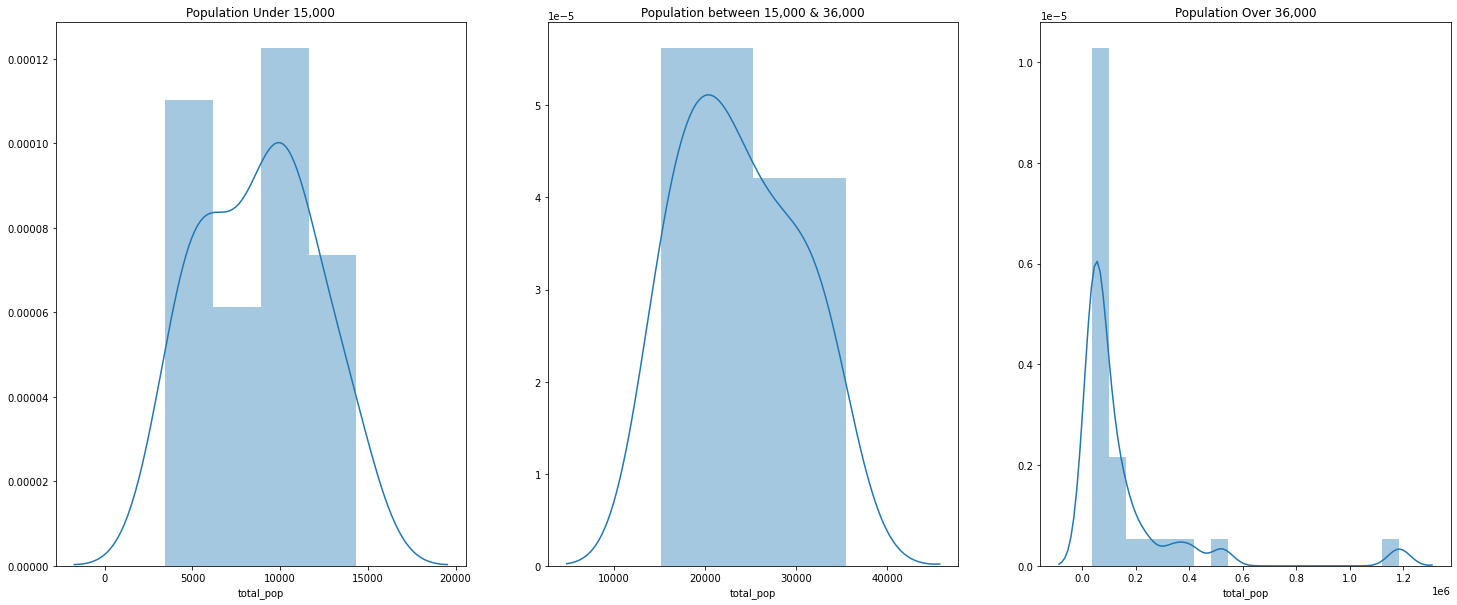

In [360]:
## start soft, use the one that's good but not great 
f, ax = plt.subplots(1,3,figsize=(25,10))
sns.distplot(df[df["county_size"]==1].total_pop,ax=ax[0])
ax[0].set_title("Population Under 15,000")
sns.distplot(df[df["county_size"]==2].total_pop,ax=ax[1])
ax[1].set_title("Population between 15,000 & 36,000")
sns.distplot(df[df["county_size"]==3].total_pop,ax=ax[2])
ax[2].set_title("Population Over 36,000")

## practice how to explain a distplot before your presentation 
## or just remove this because it isn't overly useful

Text(0, 0.5, 'Median Income for Full Time Workers')

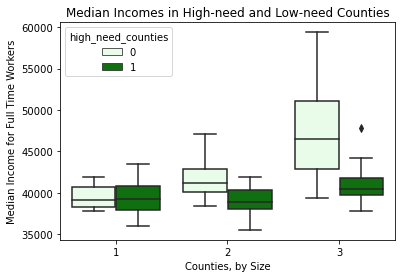

In [361]:
## In this plot we can see that median income becomes more and more 
## correlated to public healthcare needs as populations grow in size. 
sns.boxplot(x="county_size", y="med_income_FT", hue="high_need_counties", color="green", data=df )
plt.title("Median Incomes in High-need and Low-need Counties")
plt.xlabel("Counties, by Size")
plt.ylabel("Median Income for Full Time Workers") 

Text(0, 0.5, 'y')

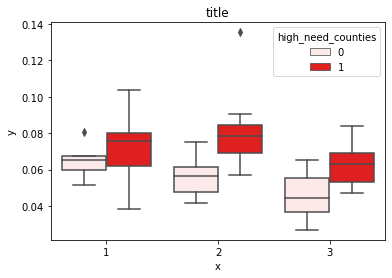

In [362]:
## In this plot we can see that there is a relationship between higher populations
## of people without high school education and a greater need for public healthcare
sns.boxplot(x="county_size", y="percentage_Grade_School", hue="high_need_counties", color="red", data=df )
plt.title("title")
plt.xlabel("x")
plt.ylabel("y") 
## high needs counties have higher rates of people who did not finish 
## highschool than other low needs counties of comparable size 

Text(0, 0.5, 'Percentage of Unemployment for Population over age 15')

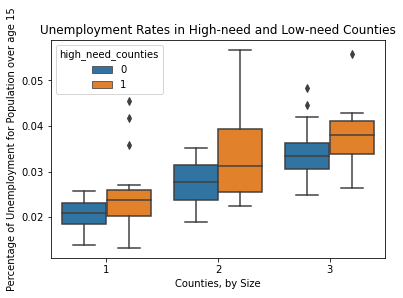

In [363]:
## In this plot we can see that there is a relationship unemployment rates and need for public healthcare
sns.boxplot(x="county_size", y="percentage_Unemployed", hue="high_need_counties", data=df )
plt.title("Unemployment Rates in High-need and Low-need Counties")
plt.xlabel("Counties, by Size")
plt.ylabel("Percentage of Unemployment for Population over age 15") 

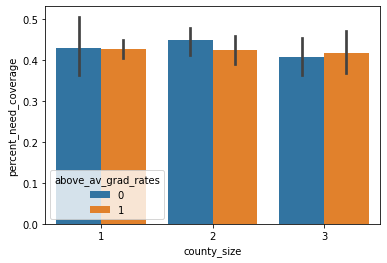

In [364]:
## this one does not visually support my hypothesis as much as the box plot above 
## interestingly, this is defining "needs" using the target 2019 variable for the first time 
sns.barplot(x="county_size",y = "percent_need_coverage", hue="above_av_grad_rates", data=df)

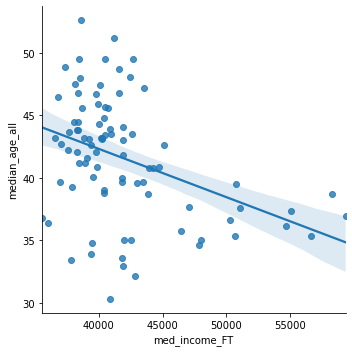

In [365]:
## this loosely correlates higher median income to lower median age
sns.lmplot(x="med_income_FT", y="median_age_all", data=df)

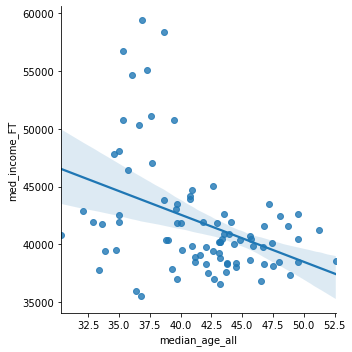

In [366]:
## flip the variables around to see if it gives a better visual representation 
sns.lmplot(x="median_age_all", y="med_income_FT", data=df)

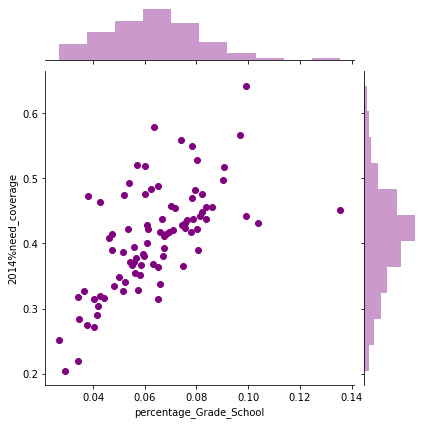

In [367]:
## this plot and the plot below indicate that educational attainment is somewhat correlated 
## to public healthcare needs, but largely within the same time frame, not as a future predictor 

sns.jointplot(x="percentage_Grade_School",y="2014%need_coverage",data=df, color="purple")

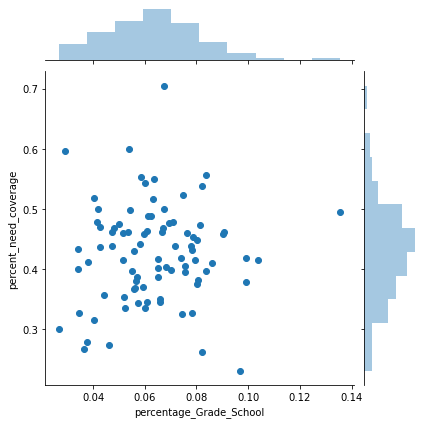

In [368]:
## this plot and the plot above indicate that educational attainment is somewhat correlated 
## to public healthcare needs, but largely within the same time frame, not as a future predictor 

sns.jointplot(x="percentage_Grade_School",y="percent_need_coverage",data=df) ## dependent variable

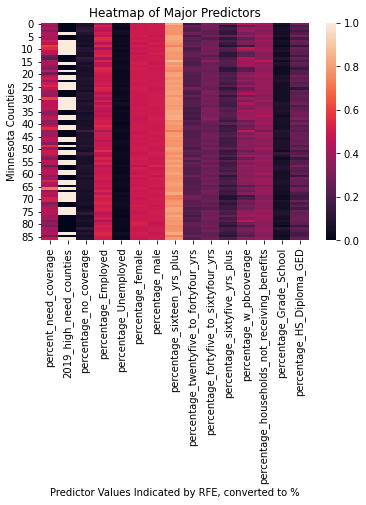

In [369]:
## trying a heatmap for giggles 
heat = df.iloc[:,2:17]
fig = sns.heatmap(heat).set_title("Heatmap of Major Predictors") ### heatmap in seaborn 
plt.xlabel("Predictor Values Indicated by RFE, converted to %")
plt.ylabel("Minnesota Counties")
plt.show()

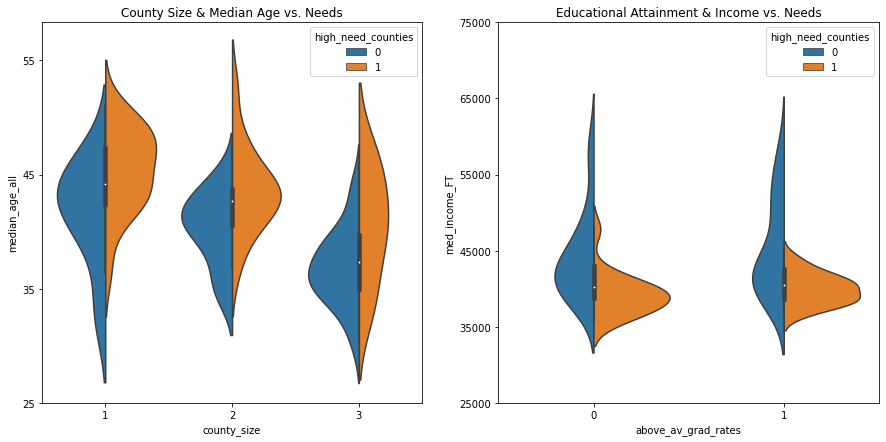

In [446]:
### violin plots
### was using plotly originally, but being interactive was not a necessary component 
f, ax = plt.subplots(1,2,figsize=(15,7))
sns.violinplot("county_size", "median_age_all", hue="high_need_counties", data= df, split=True, ax = ax[0]) 
ax[0].set_title("County Size & Median Age vs. Needs") 
ax[0].set_yticks(range(25,65,10)) 
sns.violinplot("above_av_grad_rates", "med_income_FT", hue="high_need_counties", data= df, split=True, ax = ax[1]) 
ax[1].set_title("Educational Attainment & Income vs. Needs")
ax[1].set_yticks(range(25000,80000,10000))

## in the first plot, we can see higher median age correlating to higher oublic healthcare needs
## in the second plot, we see graduation rates having little impact on median income for either

In [447]:
## originally using a violin plot in plotly, no longer using this plot 
## plot suggests that higher median age correlates positively to higher public healthcare needs
## simply, the median age in high-needs counties is higher than in low-needs counties 
## fig = px.violin(df, y="median_age_all", x="county_size", color="high_need_counties",
##               box=True, points="all")
## fig.show() 

(array([ 1.02587346,  6.4971986 , 10.60069245,  5.47132514,  4.10349385,
         1.02587346,  0.68391564,  0.34195782]),
 array([0.28891724, 0.32253032, 0.35614339, 0.38975646, 0.42336953,
        0.4569826 , 0.49059568, 0.52420875, 0.55782182]),
 <a list of 8 Patch objects>)

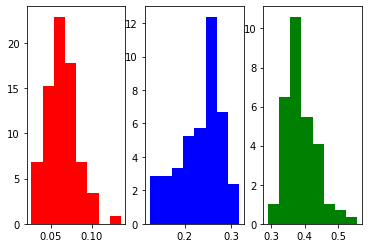

In [371]:
## quick histogram before tracking back to consider making another categorical variable 

plt.subplot(131)
plt.hist(df["percentage_Grade_School"], 8, density=1, facecolor='r')
plt.subplot(132)
plt.hist(df["percentage_HS_Diploma_GED"], 8, density=1, facecolor='b')
plt.subplot(133)
plt.hist(df["percentage_Higher_Ed"], 8, density=1, facecolor='g')

(array([ 1.02587346,  2.56468366,  7.69405097, 10.77167136,  9.7457979 ,
         3.59055712,  5.12936731,  1.02587346,  1.53881019,  1.02587346,
         0.        ,  0.51293673]),
 array([0.28891724, 0.31132596, 0.33373467, 0.35614339, 0.3785521 ,
        0.40096082, 0.42336953, 0.44577825, 0.46818696, 0.49059568,
        0.51300439, 0.53541311, 0.55782182]),
 <a list of 12 Patch objects>)

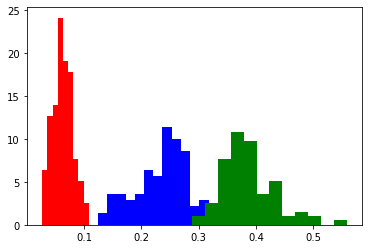

In [372]:
## the data is clearer if I put the histograms in overlapping plots 
plt.hist(df["percentage_Grade_School"], 12, density=1, facecolor='r')
plt.hist(df["percentage_HS_Diploma_GED"], 12, density=1, facecolor='b')
plt.hist(df["percentage_Higher_Ed"], 12, density=1, facecolor='g')

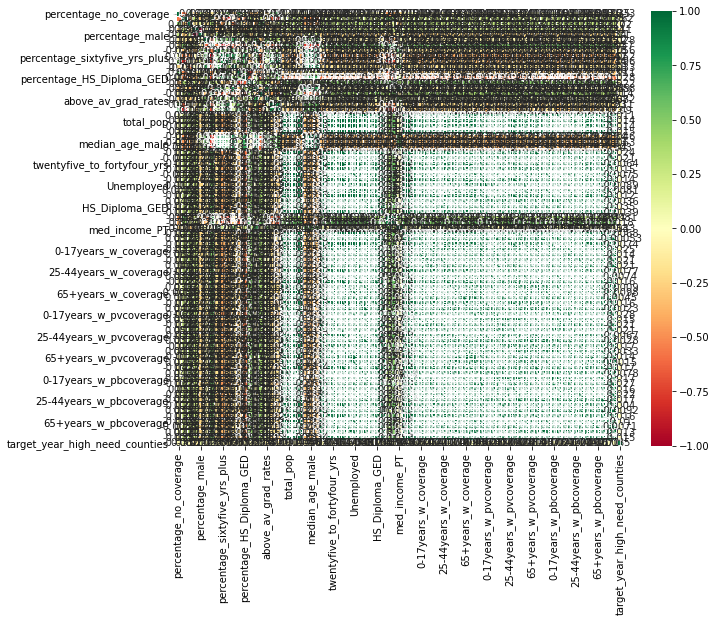

In [450]:
## correlation matrix , only works for numeric cols
sns.heatmap(df.iloc[:,4:].corr(), annot=True, cmap = "RdYlGn", linewidths = 0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [ ]:
## that went well

## NOW MOVING ON TO ADDING LINEAR REGRESSION MODELS

In [567]:
## multivariate linear regression model to predict `need_coverage` using all of the other variables
## this will establish the baseline usefullness of the variables, original models were around 36%

X = df.iloc[:,4:] ## all columns and rows 3-end (exclude county name and dependent variable)
Y = df["need_coverage"] 
 
lr = linear_model.LinearRegression() 

model_0 = lr.fit(X, Y) 

In [568]:
## Calculating the R^2 of our model 
print("R^2 = " + str(model_0.score(X, Y))) 

R^2 = 0.5220283411598641


In [569]:
## multivariate linear regression model to predict `percent_need_coverage` using all of the other variables
## this will establish the baseline usefullness of the variables, original models were around 45%

X = df.iloc[:,4:] ## all columns and rows 3-end (exclude county name and dependent variable)
Y = df["percent_need_coverage"] 

model_1 = lr.fit(X, Y) 
print("R^2 = " + str(model_1.score(X, Y))) 

R^2 = 0.661615558664994


In [570]:
## it appears as if the variable manipulation I did above has increased model accuracy by 22% 

In [596]:
## now lets use RFE again (first time in this draft) to narrow down our variables 
X = df.drop(columns=["2019_high_need_counties","county_index","need_coverage","percent_need_coverage"], axis = 1)
Y = df["percent_need_coverage"]

rfe = RFE(lr, n_features_to_select=24)
model_RFE = rfe.fit(X,Y)

In [597]:
## can't figure out why this RFE still includes excluded variables, tried several different ways 
print("Ideal features for target variable prediction:")
print(sorted(zip(map(lambda X: round(X, 4), rfe.ranking_), df.columns)))

Ideal features for target variable prediction:
[(1, '0-17years_no_pbcoverage'), (1, '18-24years_no_pbcoverage'), (1, '2014_need_coverage'), (1, '2019_high_need_counties'), (1, '25-44years_no_pbcoverage'), (1, 'county_index'), (1, 'need_coverage'), (1, 'percent_need_coverage'), (1, 'percentage_Employed'), (1, 'percentage_Grade_School'), (1, 'percentage_HS_and_Higher'), (1, 'percentage_Higher_Ed'), (1, 'percentage_Unemployed'), (1, 'percentage_female'), (1, 'percentage_fortyfive_to_sixtyfour_yrs'), (1, 'percentage_households_not_receiving_benefits'), (1, 'percentage_male'), (1, 'percentage_no_coverage'), (1, 'percentage_sixteen_yrs_plus'), (1, 'percentage_sixtyfive_yrs_plus'), (1, 'percentage_twentyfive_to_fortyfour_yrs'), (1, 'percentage_w_pbcoverage'), (1, 'total_pop'), (1, 'total_pop_male'), (2, '45-64years_no_pbcoverage'), (3, 'total_w_pvcoverage'), (4, 'median_age_all'), (5, 'total_pop_female'), (6, '65+years_w_pvcoverage'), (7, 'median_age_male'), (8, '0-17years_no_pvcoverage'), (9

In [573]:
## all ideal features come from the created percentages, so let's run a regression with just %ages

X = df.iloc[:,4:18] ## all columns and rows 3-end (exclude county name and dependent variable)
Y = df["percent_need_coverage"] 
X = sm.add_constant(X) # Adding a constant
model_2 = lr.fit(X, Y) 
print("R^2 = " + str(model_2.score(X, Y))) 

## I can't figure out why this value is coming out negative, ask Jeff or Favio 

R^2 = -0.37216596007214164


In [575]:
X = df.iloc[:,4:25] ## expanding variables a bit further 
Y = df["percent_need_coverage"] 
lr = linear_model.LinearRegression() 
model_3 = lr.fit(X, Y) 
print("R^2 = " + str(model_3.score(X, Y))) 

R^2 = 0.10153749277617696


In [ ]:
## 10 best variables for a Linear Regression, according to the RFE 
['percentage_Employed','percentage_Unemployed','percentage_female',
'percentage_fortyfive_to_sixtyfour_yrs','percentage_male',
'percentage_no_coverage','percentage_sixteen_yrs_plus','percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_w_pbcoverage']

In [607]:
## using the 10 best variables from the RFE
X = df[['percentage_Employed','percentage_Unemployed','percentage_female',
'percentage_fortyfive_to_sixtyfour_yrs','percentage_male',
'percentage_no_coverage','percentage_sixteen_yrs_plus','percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_w_pbcoverage']]
Y = df["percent_need_coverage"] 
X = sm.add_constant(X) # Adding a constant
model_4 = lr.fit(X, Y) 
print("R^2 = " + str(model_4.score(X, Y))) 

R^2 = -0.27842946822780634


In [ ]:
## 20 best variables for a Linear Regression, according to the RFE 
['18-24years_no_pbcoverage','2014_need_coverage',
'25-44years_no_pbcoverage','percentage_Employed','percentage_Grade_School',
'percentage_HS_and_Higher','percentage_Higher_Ed','percentage_Unemployed',
'percentage_female','percentage_fortyfive_to_sixtyfour_yrs',
'percentage_households_not_receiving_benefits','percentage_male','total_pop_female',
'percentage_no_coverage','percentage_sixteen_yrs_plus','percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_w_pbcoverage','total_pop','total_pop_male']

In [609]:
## using the 19 best variables from the RFE
X = df[['18-24years_no_pbcoverage','2014_need_coverage','25-44years_no_pbcoverage',
'percentage_Employed','percentage_Grade_School',
'percentage_HS_and_Higher','percentage_Higher_Ed','percentage_Unemployed',
'percentage_female','percentage_fortyfive_to_sixtyfour_yrs',
'percentage_households_not_receiving_benefits','percentage_male','total_pop_female',
'percentage_no_coverage','percentage_sixteen_yrs_plus','percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_w_pbcoverage','total_pop','total_pop_male']]
Y = df["percent_need_coverage"] 
X = sm.add_constant(X) # Adding a constant
model_5 = lr.fit(X, Y) 
print("R^2 = " + str(model_5.score(X, Y))) 

R^2 = 0.17423920285424288


In [611]:
## fiddling with variables to get close to the 66% accuracy you get with all 80some variables 
X = df[['percentage_no_coverage', 
         'percentage_Employed',
         'percentage_Unemployed', 
         'percentage_female', 
         'percentage_male',
         'percentage_sixteen_yrs_plus',
         'percentage_twentyfive_to_fortyfour_yrs',
         'percentage_fortyfive_to_sixtyfour_yrs',
         'percentage_sixtyfive_yrs_plus', 
         'percentage_w_pbcoverage',
         'percentage_households_not_receiving_benefits', 
         
         'percentage_Grade_School', 
         'percentage_HS_Diploma_GED', 
         'percentage_Higher_Ed', 
         'percentage_HS_and_Higher', 

         'county_size', 
         'above_av_grad_rates', 
         'high_need_counties', 
                  
         '2014%need_coverage', 
         '2014_need_coverage', 
         
         'total_pop', 
         'total_pop_male', 
         'total_pop_female',
         'median_age_all', 
         'median_age_male', 
         'median_age_female', 
         '0-17years',
         '18-24years', 
         'twentyfive_to_fortyfour_yrs', 
         'fortyfive_to_sixtyfour_yrs', 
         'sixtyfive_yrs_plus', 
         
         'Employed',
         'Unemployed', 
         'Not_in_Labor_Force', 
         'total_sixteen_yrs_plus', 
         
         'Grade_School', 
         'HS_Diploma_GED', 
         'Higher_Ed', 
         
         'total_median_income',
         'med_income_FT', 
         'med_income_PT',
         
         'total_households', 
         'households_receiving_benefits',
         'households_not_receiving_benefits',
         
         '0-17years_w_coverage', 
         '0-17years_no_coverage',
         '18-24years_w_coverage', 
         '18-24years_no_coverage',
         '25-44years_w_coverage', 
         '25-44years_no_coverage',
         '45-64years_w_coverage', 
         '45-64years_no_coverage',
         '65+years_w_coverage', 
         '65+years_no_coverage', 
         'total_w_coverage',
         'total_no_coverage', 
         
         '0-17years_w_pvcoverage',
         '0-17years_no_pvcoverage', 
         '18-24years_w_pvcoverage',
         '18-24years_no_pvcoverage', 
         '25-44years_w_pvcoverage',
         '25-44years_no_pvcoverage', 
         '45-64years_w_pvcoverage',
         '45-64years_no_pvcoverage', 
         '65+years_w_pvcoverage',
         '65+years_no_pvcoverage', 
         'total_w_pvcoverage', 
         'total_no_pvcoverage', 
         
         '0-17years_w_pbcoverage', 
         '0-17years_no_pbcoverage',
         '18-24years_w_pbcoverage', 
         '18-24years_no_pbcoverage',
         '25-44years_w_pbcoverage', 
         '25-44years_no_pbcoverage',
         '45-64years_w_pbcoverage', 
         '45-64years_no_pbcoverage',
         '65+years_w_pbcoverage', 
         '65+years_no_pbcoverage', 
         'total_w_pbcoverage',
         'total_no_pbcoverage']]

Y = df["percent_need_coverage"] 
X = sm.add_constant(X) # Adding a constant
model_6 = lr.fit(X, Y) 

print("R^2 = " + str(model_6.score(X, Y))) 

R^2 = -0.12435084090021098


In [ ]:
df[['county_index', 
         'need_coverage', ## variable from the target year 
         'percent_need_coverage', ## linear target variable 
         '2019_high_need_counties', ## logistic target variable        
         
         'percentage_no_coverage', ## 3
         'percentage_Employed',
         'percentage_Unemployed', 
         'percentage_female', 
         'percentage_male', ## 7
         'percentage_sixteen_yrs_plus',
         'percentage_twentyfive_to_fortyfour_yrs',
         'percentage_fortyfive_to_sixtyfour_yrs',
         'percentage_sixtyfive_yrs_plus', 
         'percentage_w_pbcoverage', ## 12
         'percentage_households_not_receiving_benefits', ## good predictor variables converted to percentages 
         
         'percentage_Grade_School', 
         'percentage_HS_Diploma_GED', ## 15 
         'percentage_Higher_Ed', 
         'percentage_HS_and_Higher', ## education variables converted to percentages to continue testing my hypothesis 

         'county_size', 
         'above_av_grad_rates', 
         'high_need_counties', ## generated categorical variable that I think will be usefull in visualizations 
                  
         '2014%need_coverage', ## 21
         '2014_need_coverage', ## target variables, but from 2014 instead of 2019 
         
         'total_pop', 
         'total_pop_male', 
         'total_pop_female',
         'median_age_all', 
         'median_age_male', 
         'median_age_female', 
         '0-17years',
         '18-24years', 
         'twentyfive_to_fortyfour_yrs', 
         'fortyfive_to_sixtyfour_yrs', 
         'sixtyfive_yrs_plus', ## population and age breakdowns 
         
         'Employed',
         'Unemployed', 
         'Not_in_Labor_Force', 
         'total_sixteen_yrs_plus', ## data about the labor force 
         
         'Grade_School', 
         'HS_Diploma_GED', 
         'Higher_Ed', ## educational attainment data 
         
         'total_median_income',
         'med_income_FT', 
         'med_income_PT', ## income data 
         
         'total_households', 
         'households_receiving_benefits',
         'households_not_receiving_benefits', ## households receiving SNAP and foodstamps data
         
         '0-17years_w_coverage', 
         '0-17years_no_coverage',
         '18-24years_w_coverage', 
         '18-24years_no_coverage',
         '25-44years_w_coverage', 
         '25-44years_no_coverage',
         '45-64years_w_coverage', 
         '45-64years_no_coverage',
         '65+years_w_coverage', 
         '65+years_no_coverage', 
         'total_w_coverage',
         'total_no_coverage', ## population with and without ANY form of healthcare coverage 
         
         '0-17years_w_pvcoverage',
         '0-17years_no_pvcoverage', 
         '18-24years_w_pvcoverage',
         '18-24years_no_pvcoverage', 
         '25-44years_w_pvcoverage',
         '25-44years_no_pvcoverage', 
         '45-64years_w_pvcoverage',
         '45-64years_no_pvcoverage', 
         '65+years_w_pvcoverage',
         '65+years_no_pvcoverage', 
         'total_w_pvcoverage', 
         'total_no_pvcoverage', ## population with and without a private form of healthcare coverage
         
         '0-17years_w_pbcoverage', 
         '0-17years_no_pbcoverage',
         '18-24years_w_pbcoverage', 
         '18-24years_no_pbcoverage',
         '25-44years_w_pbcoverage', 
         '25-44years_no_pbcoverage',
         '45-64years_w_pbcoverage', 
         '45-64years_no_pbcoverage',
         '65+years_w_pbcoverage', 
         '65+years_no_pbcoverage', 
         'total_w_pbcoverage',
         'total_no_pbcoverage' ## population with and without a public form of healthcare coverage
         ]]

In [382]:
## pause here, narrow down ideal variables after mentor meeting 

In [385]:
## let's run another RFE but for an OLS regression to predict "high_need_counties"

X = df.iloc[:,4:]
Y = df["2019_high_need_counties"]

rfe = RFE(lr, n_features_to_select=13)
model_RFE2 = rfe.fit(X,Y)

In [386]:
print("Ideal features for target variable prediction:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), df.columns)))

Ideal features for target variable prediction:
[(1, '2019_high_need_counties'), (1, 'county_index'), (1, 'need_coverage'), (1, 'percent_need_coverage'), (1, 'percentage_Employed'), (1, 'percentage_HS_and_Higher'), (1, 'percentage_Higher_Ed'), (1, 'percentage_female'), (1, 'percentage_male'), (1, 'percentage_no_coverage'), (1, 'percentage_sixteen_yrs_plus'), (1, 'percentage_sixtyfive_yrs_plus'), (1, 'percentage_twentyfive_to_fortyfour_yrs'), (2, 'percentage_fortyfive_to_sixtyfour_yrs'), (3, 'percentage_HS_Diploma_GED'), (4, 'percentage_households_not_receiving_benefits'), (5, 'percentage_w_pbcoverage'), (6, 'percentage_Unemployed'), (7, 'total_pop_male'), (8, 'percentage_Grade_School'), (9, '2014_need_coverage'), (10, 'total_pop'), (11, 'total_no_coverage'), (12, 'median_age_all'), (13, 'total_w_coverage'), (14, '0-17years_no_pbcoverage'), (15, 'median_age_male'), (16, '18-24years_w_pbcoverage'), (17, '18-24years_no_pbcoverage'), (18, 'median_age_female'), (19, '0-17years_w_pbcoverage')

In [420]:
## duplicate this column on the fly to accomodate OLS syntax requirements 
df["target_year_high_need_counties"] = df['2019_high_need_counties']

In [426]:
# Next, let's look at the interaction effect of floodborn and non-floodborn in Mississippi. 
# Remember to control for race, sex, and birth year. 

model_4 = smf.ols(formula='target_year_high_need_counties ~  med_income_FT*above_av_grad_rates + high_need_counties + median_age_all', data=df).fit()

In [427]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     target_year_high_need_counties   R-squared:                       0.011
Model:                                        OLS   Adj. R-squared:                 -0.050
Method:                             Least Squares   F-statistic:                    0.1829
Date:                            Tue, 16 Feb 2021   Prob (F-statistic):              0.968
Time:                                    23:25:15   Log-Likelihood:                -62.650
No. Observations:                              87   AIC:                             137.3
Df Residuals:                                  81   BIC:                             152.1
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1966      1.105      0.178      0.859      -2.002       2.395
med_income_FT                      9.382e-06   1.73e-05      0.541      0.590   -2.51e-05    4.39e-05
above_av_grad_rates                   0.3837      0.999      0.384      0.702      -1.604       2.371
med_income_FT:above_av_grad_rates -1.104e-05   2.29e-05     -0.482      0.631   -5.66e-05    3.46e-05
high_need_counties                    0.0447      0.146      0.306      0.761      -0.246       0.336
median_age_all                       -0.0016      0.020     -0.078      0.938      -0.041       0.038
==============================================================================
Omnibus:                      825.003   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.895
Skew:                          -0.019   Prob(JB):                     0.000961
Kurtosis:                       1.043   Cond. No.                     1.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## TAKE A SWING AT A LOGISTIC REGRESSION 

In [387]:
## with these variables accuracy is 39%, [[0,11],[0,7]] with all counties predicted to be high-need, test_size=0.2
'percentage_Employed', 'percentage_HS_and_Higher', 'percentage_Higher_Ed', 'percentage_female',
'percentage_male','percentage_no_coverage','percentage_sixteen_yrs_plus',
'percentage_sixtyfive_yrs_plus', 'percentage_twentyfive_to_fortyfour_yrs'
## reducing test_size to .1 from .2 to hopefully increase effectiveness of the model 
## accuracy increased to 56% using a larger training set of data 

('percentage_sixtyfive_yrs_plus', 'percentage_twentyfive_to_fortyfour_yrs')

In [388]:
## with these variables accuracy is 44%, [[2,9],[1,6]] with ten counties still classed incorrectly, test_size=0.2
'percentage_no_coverage','percentage_Employed','percentage_Unemployed', 
'percentage_female','percentage_male','percentage_sixteen_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_fortyfive_to_sixtyfour_yrs',
'percentage_sixtyfive_yrs_plus','percentage_w_pbcoverage',
'percentage_households_not_receiving_benefits','percentage_Grade_School', 
'percentage_HS_Diploma_GED','percentage_Higher_Ed','percentage_HS_and_Higher', 
'county_size','above_av_grad_rates','high_need_counties','2014%need_coverage', 
'2014_need_coverage'
## reducing test_size to .1 from .2 to hopefully increase effectiveness of the model 
## accuracy increased to 56% using a larger training set of data 

'2014_need_coverage'

In [389]:
## most accurate model 
## 56% accuracy at test_size=0.1  [[2,3],[2,2]]
'percentage_no_coverage','percentage_w_pbcoverage',
'percentage_HS_Diploma_GED','percentage_Grade_School',
'above_av_grad_rates','median_age_all','2014%need_coverage',
'percentage_Employed','percentage_Unemployed'
## 33% accuracy at test_size=0.2 [[0,11],[1,6]]

('percentage_Employed', 'percentage_Unemployed')

In [600]:
### Logistic regression with sklearn 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report 

X = df[['percentage_no_coverage','percentage_w_pbcoverage',
'percentage_HS_Diploma_GED','percentage_Grade_School',
'above_av_grad_rates','median_age_all','2014%need_coverage',
'percentage_Employed','percentage_Unemployed'
       ]]

y = df["2019_high_need_counties"] 

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=87)

In [602]:
logmodel = LogisticRegression(solver="liblinear")
logmodel.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

In [603]:
predictions = logmodel.predict(X_test)

In [604]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.60      0.60      0.60         5

    accuracy                           0.56         9
   macro avg       0.55      0.55      0.55         9
weighted avg       0.56      0.56      0.56         9



[[2 2]
 [2 3]]


[Text(0, 0.5, 'Low-need'), Text(0, 1.5, 'High-need')]

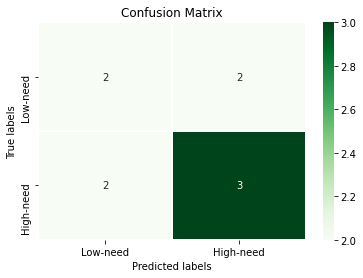

In [605]:
from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix(y_test, predictions)
print(cmatrix)

ax= plt.subplot()
sns.heatmap(cmatrix, annot=True, ax = ax, linewidths=1, cmap="Greens"); # Use `annot=True` to annotate cells

# Set labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Low-need', 'High-need']); ax.yaxis.set_ticklabels(['Low-need', 'High-need'])

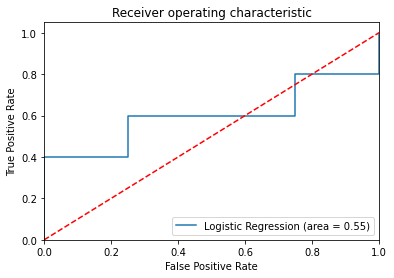

In [411]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = {})'.format(logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## DO THE BELOW MODELS TOMORROW, BUT HURRY SO YOU CAN TYPE UP RESULTS 

In [452]:
df.drop("target_year_high_need_counties", axis=1, inplace=True)

In [462]:
from sklearn.model_selection import train_test_split 

X = df.drop(columns=["2019_high_need_counties","county_index","need_coverage","percent_need_coverage"], axis = 1)
y = df["2019_high_need_counties"] 


In [463]:
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=42)

In [457]:
from sklearn import svm # support vector machine 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics # accuracy measure 

In [477]:
X.shape

(87, 80)

In [465]:
y.shape

(87,)

In [466]:
X.head()

,percentage_no_coverage,percentage_Employed,percentage_Unemployed,percentage_female,percentage_male,percentage_sixteen_yrs_plus,percentage_twentyfive_to_fortyfour_yrs,percentage_fortyfive_to_sixtyfour_yrs,percentage_sixtyfive_yrs_plus,percentage_w_pbcoverage,...,18-24years_w_pbcoverage,18-24years_no_pbcoverage,25-44years_w_pbcoverage,25-44years_no_pbcoverage,45-64years_w_pbcoverage,45-64years_no_pbcoverage,65+years_w_pbcoverage,65+years_no_pbcoverage,total_w_pbcoverage,total_no_pbcoverage
0,0.081809,0.409108,0.036081,0.492420,0.507580,0.846279,0.163430,0.322225,0.287522,0.477324,...,224,576,623,1942,1330,3791,4432,51,7620,8150
1,0.073229,0.531173,0.041042,0.499869,0.500131,0.779383,0.271287,0.288586,0.108035,0.242611,...,4087,22931,12140,78000,12293,84246,34861,935,81594,252118
2,0.115253,0.475205,0.022505,0.497862,0.502138,0.782294,0.213855,0.289103,0.183009,0.372812,...,627,1606,1374,5625,1859,7637,5664,81,12292,20292
3,0.139955,0.449642,0.055730,0.499204,0.500796,0.776616,0.222323,0.244496,0.135976,0.378504,...,1339,5166,2752,7247,2354,8663,5758,132,17122,27610
4,0.091739,0.505413,0.044510,0.500436,0.499564,0.776372,0.288584,0.245126,0.127553,0.302591,...,864,2675,2115,9087,1543,7985,4516,47,11795,26670


In [467]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: 2019_high_need_counties, dtype: int64

In [468]:
### linear-SVM 
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(train_X, train_y)
prediction1 = model.predict(test_X) 
print("Accuracy for linear SVM is" ,metrics.accuracy_score(prediction1, test_y))

Accuracy for linear SVM is 0.4090909090909091


In [469]:
### Logistic Regression 
model = LogisticRegression()
model.fit(train_X, train_y)
prediction2 = model.predict(test_X) 
print("Accuracy for a Logistic Regression is" ,metrics.accuracy_score(prediction2, test_y))

Accuracy for a Logistic Regression is 0.36363636363636365


C:\Users\adria\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [470]:
### Decision Tree
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
prediction3 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction3, test_y))

Accuracy of the Decision Tree is 0.5


In [471]:
### KNN
model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y)
prediction4 = model.predict(test_X) 
print("Accuracy of the KNN is" ,metrics.accuracy_score(prediction4, test_y))

Accuracy of the KNN is 0.36363636363636365


In [472]:
### Naive Bayes
model = GaussianNB()
model.fit(train_X, train_y)
prediction5 = model.predict(test_X) 
print("Accuracy of the Naive Bayes model is" ,metrics.accuracy_score(prediction5, test_y))

Accuracy of the Naive Bayes model is 0.5909090909090909


In [473]:
### Random FOrest
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_y)
prediction6 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction6, test_y))

Accuracy of the Decision Tree is 0.45454545454545453


In [489]:
## try these again with a smaller dataset 
df1 = df.iloc[:,:25]

In [500]:
df1.columns

Index(['county_index', 'need_coverage', 'percent_need_coverage',
       '2019_high_need_counties', 'percentage_no_coverage',
       'percentage_Employed', 'percentage_Unemployed', 'percentage_female',
       'percentage_male', 'percentage_sixteen_yrs_plus',
       'percentage_twentyfive_to_fortyfour_yrs',
       'percentage_fortyfive_to_sixtyfour_yrs',
       'percentage_sixtyfive_yrs_plus', 'percentage_w_pbcoverage',
       'percentage_households_not_receiving_benefits',
       'percentage_Grade_School', 'percentage_HS_Diploma_GED',
       'percentage_Higher_Ed', 'percentage_HS_and_Higher', 'county_size',
       'above_av_grad_rates', 'high_need_counties', '2014%need_coverage',
       '2014_need_coverage', 'total_pop'],
      dtype='object')

In [490]:
from sklearn.model_selection import train_test_split 

X = df1.drop(columns=["2019_high_need_counties","county_index","need_coverage","percent_need_coverage"], axis = 1)
y = df1["2019_high_need_counties"] 

In [491]:
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=42)

In [492]:
X.shape

(87, 21)

In [493]:
y.shape

(87,)

In [494]:
### linear-SVM 
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(train_X, train_y)
prediction1 = model.predict(test_X) 
print("Accuracy for linear SVM is" ,metrics.accuracy_score(prediction1, test_y))

Accuracy for linear SVM is 0.2727272727272727


In [495]:
### Logistic Regression 
model = LogisticRegression()
model.fit(train_X, train_y)
prediction2 = model.predict(test_X) 
print("Accuracy for a Logistic Regression is" ,metrics.accuracy_score(prediction2, test_y))

Accuracy for a Logistic Regression is 0.4090909090909091


In [496]:
### Decision Tree
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
prediction3 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction3, test_y))

Accuracy of the Decision Tree is 0.5454545454545454


In [497]:
### KNN
model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y)
prediction4 = model.predict(test_X) 
print("Accuracy of the KNN is" ,metrics.accuracy_score(prediction4, test_y))

Accuracy of the KNN is 0.36363636363636365


In [498]:
### Naive Bayes
model = GaussianNB()
model.fit(train_X, train_y)
prediction5 = model.predict(test_X) 
print("Accuracy of the Naive Bayes model is" ,metrics.accuracy_score(prediction5, test_y))

Accuracy of the Naive Bayes model is 0.5


In [499]:
### Random FOrest
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_y)
prediction6 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction6, test_y))

Accuracy of the Decision Tree is 0.22727272727272727


In [514]:
## try last time with even smaller group of variables (the ones that got 56% accuracy in the confusion matrix)

In [517]:
df2 = df[['2019_high_need_counties','percentage_no_coverage','percentage_w_pbcoverage',
'percentage_HS_Diploma_GED','percentage_Grade_School',
'above_av_grad_rates','median_age_all','2014%need_coverage',
'percentage_Employed','percentage_Unemployed']]

In [539]:
X = df2.drop("2019_high_need_counties", axis = 1)
y = df2["2019_high_need_counties"] 

In [558]:
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=42)

In [559]:
X.shape

(87, 9)

In [560]:
y.shape

(87,)

In [561]:
### linear-SVM 
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(train_X, train_y)
prediction1 = model.predict(test_X) 
print("Accuracy for linear SVM is" ,metrics.accuracy_score(prediction1, test_y))

Accuracy for linear SVM is 0.4090909090909091


In [562]:
### Logistic Regression 
model = LogisticRegression()
model.fit(train_X, train_y)
prediction2 = model.predict(test_X) 
print("Accuracy for a Logistic Regression is" ,metrics.accuracy_score(prediction2, test_y))

Accuracy for a Logistic Regression is 0.45454545454545453


In [563]:
### Decision Tree
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
prediction3 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction3, test_y))

Accuracy of the Decision Tree is 0.3181818181818182


In [564]:
### KNN
model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y)
prediction4 = model.predict(test_X) 
print("Accuracy of the KNN is" ,metrics.accuracy_score(prediction4, test_y))

Accuracy of the KNN is 0.5


In [565]:
### Naive Bayes
model = GaussianNB()
model.fit(train_X, train_y)
prediction5 = model.predict(test_X) 
print("Accuracy of the Naive Bayes model is" ,metrics.accuracy_score(prediction5, test_y))

Accuracy of the Naive Bayes model is 0.4090909090909091


In [566]:
### Random FOrest
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_y)
prediction6 = model.predict(test_X) 
print("Accuracy of the Decision Tree is" ,metrics.accuracy_score(prediction6, test_y))

Accuracy of the Decision Tree is 0.22727272727272727
